In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm

from sklearn import preprocessing
from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.utils.data as data_utils
from torch.nn import Linear, Conv1d, ConvTranspose1d

from torch.nn import Sequential as Seq, Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.functional import F
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm

from tqdm.notebook import tqdm
import json

In [2]:
from models import DriverDatasets, VAElatentdynamics

## Load the training data sets

In [5]:
trainloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/trainloader_onecat.pth')
valloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/valloader_onecat.pth')
testloader=torch.load('/home/jovyan/neural-dsds/neural-dsds/data/testloader_onecat.pth')

## Load the model weights

In [6]:
# best model: n=4, epochs = 500
model = VAElatentdynamics(n_bins=35,n_latent=3,n_hidden=20)
j = 4
epochs = 500
# Check if there is a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)
mod_weights = "LatentDynamicsModels/VAELatentDynamics3var_CNN_n{}_{}epochs_Sigmoid_magnitude_expdynLin_nobias_updatedata_Li_dLdt2_c1e2".format(j,epochs)
model.load_state_dict(torch.load(mod_weights))

<All keys matched successfully>

In [8]:
def inference(model,dataloader,device,nlatent,singlecat=True):
    model.eval()
    dataset = dataloader.dataset

    ntargets = nlatent #+2
    nmoms = 4
    nrates = 3
    bs = 500
    print(len(dataset))
    
    pred = np.zeros((len(dataset),ntargets,nrates))
    real = np.zeros((len(dataset),ntargets,nrates))
    
    #[500, 3, 3, 2]) torch.Size([500, 3, 3, 2] 
    if singlecat:
        realM = np.zeros((len(dataset),nmoms,nrates))
        realdMdt = np.zeros((len(dataset),nmoms,nrates))
    else:
        realM = np.zeros((len(dataset),3,3,2))
        realdMdt = np.zeros((len(dataset),3,3,2))    
    
    
    realbin1 = np.zeros((len(dataset),2,35))
    realbin0 = np.zeros((len(dataset),2,35))
    predbin0 = np.zeros((len(dataset),2,35))
    predbin1 = np.zeros((len(dataset),2,35))
 
    Lt0= np.zeros((len(dataset),ntargets))
    predL = np.zeros((len(dataset),ntargets))
    realL = np.zeros((len(dataset),ntargets))

    jj = 0
    i = 0

    for data in dataloader:
        M,dMdt,bin0,bin1coal,bin1condevap,binmag,M1,dM1dt,M2,dM2dt=data
        bin1 = bin1coal 
        bin0 = bin0.to(device)
        bin1 = bin1.to(device)
        binmag = binmag.to(device)
        
        normRt0,normRt1,Lit1,Lit1_pred,binmagRt0,binmagRt1,Lit0,mu0,logvar0,mu1,logvar1 = model(torch.Tensor(bin0).float(),
                        torch.Tensor(bin1).float(),binmag[:,0:2].float(),binmag[:,2:4].float())
        bs = normRt0.size(0)
        
        normbin0 = bin0.float()*torch.broadcast_to(binmag[:,0:2].float().unsqueeze(dim=2),(bs,2,35))
        normbin1 = bin1.float()*torch.broadcast_to(binmag[:,2:4].float().unsqueeze(dim=2),(bs,2,35))
        
        if normRt0 is not(None):
            if singlecat:
                realM[jj:jj+bs,:,:] = M1.cpu().detach().numpy().reshape(bs,nmoms,nrates)
                realdMdt[jj:jj+bs,:,:] = dM1dt.cpu().detach().numpy().reshape(bs,nmoms,nrates)
            else:
                realM[jj:jj+bs,:,:] = M2.cpu().detach().numpy().reshape(bs,3,3,2)
                realdMdt[jj:jj+bs,:,:] = dM2dt.cpu().detach().numpy().reshape(bs,3,3,2)
            realbin0[jj:jj+bs,:] = normbin0.cpu().detach().numpy().reshape(bs,2,35)
            realbin1[jj:jj+bs,:] = normbin1.cpu().detach().numpy().reshape(bs,2,35)
            predbin0[jj:jj+bs,:] = normRt0.cpu().detach().numpy().reshape(bs,2,35)
            predbin1[jj:jj+bs,:] = normRt1.cpu().detach().numpy().reshape(bs,2,35)
            predL[jj:jj+bs,:] = Lit1_pred.cpu().detach().numpy().reshape(bs,ntargets)
            realL[jj:jj+bs,:] = Lit1.cpu().detach().numpy().reshape(bs,ntargets)
            Lt0[jj:jj+bs,:] = Lit0.cpu().detach().numpy().reshape(bs,ntargets)
            
            jj=jj+bs
            i = i+1
        else:
            break

    return realM,realdMdt,realbin0,realbin1,predbin0,predbin1,predL,realL,Lt0

In [9]:
nlatent = 3
sc = False
trainM,traindMdt,trainrealbin0,trainrealbin1,trainpredbin0,trainpredbin1,trainpredL,trainrealL,trainrealL0=inference(model,trainloader,device,nlatent,singlecat=sc)
valM,valdMdt,valrealbin0,valrealbin1,valpredbin0,valpredbin1,valpredL,valrealL,valrealL0=inference(model,valloader,device,nlatent,singlecat=sc)
testM,testdMdt,testrealbin0,testrealbin1,testpredbin0,testpredbin1,testpredL,testrealL,testrealL0=inference(model,testloader,device,nlatent,singlecat=sc)

52000
26000
26214


## Visualize the reconstructed DSD

[21455 44182 18045 21538 49458 44093  4121  7197 48881  9182 33664 29865
 39041 21188  9922 45593]


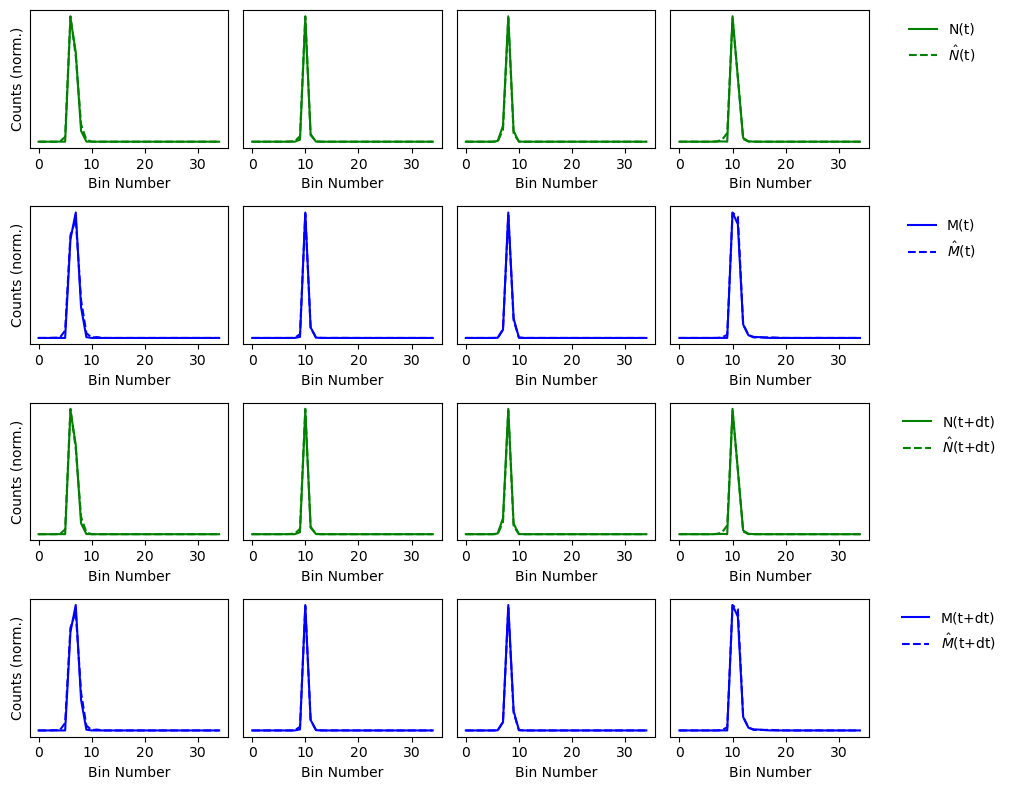

In [10]:
nw = 4

plotdiff = False

if plotdiff:
    nr = 6
    vsz = 12
else:
    nr = 4
    vsz = 8

fig, axes = plt.subplots(nrows=nr, ncols=nw, figsize=(10,vsz))

nn = np.random.choice(trainrealbin1.shape[0],nw**2)

print(nn)

for i in range(0,nw):
    axes[0,i].plot(trainrealbin0[nn[i],0,:],c='g',linestyle='solid',label=r'N(t)')
    axes[0,i].plot(trainpredbin0[nn[i],0,:],c='g',linestyle='dashed',label=r'$\hat{N}$(t)')
    
    axes[1,i].plot(trainrealbin0[nn[i],1,:],c='b',linestyle='solid',label=r'M(t)')
    axes[1,i].plot(trainpredbin0[nn[i],1,:],c='b',linestyle='dashed',label=r'$\hat{M}$(t)')
    
    axes[2,i].plot(trainrealbin1[nn[i],0,:],c='g',linestyle='solid',label=r'N(t+dt)')
    axes[2,i].plot(trainpredbin1[nn[i],0,:],c='g',linestyle='dashed',label=r'$\hat{N}$(t+dt)')

    axes[3,i].plot(trainrealbin1[nn[i],1,:],c='b',linestyle='solid',label=r'M(t+dt)')
    axes[3,i].plot(trainpredbin1[nn[i],1,:],c='b',linestyle='dashed',label=r'$\hat{M}$(t+dt)')

    axes[0,i].set_xlabel('Bin Number')
    axes[1,i].set_xlabel('Bin Number')
    axes[2,i].set_xlabel('Bin Number')
    axes[3,i].set_xlabel('Bin Number')
    axes[0,0].set_ylabel('Counts (norm.)')
    axes[1,0].set_ylabel('Counts (norm.)')
    axes[2,0].set_ylabel('Counts (norm.)')
    axes[3,0].set_ylabel('Counts (norm.)')
    
    if plotdiff:
        axes[4,i].plot(trainrealbin1[nn[i],0,:]-trainrealbin0[nn[i],0,:],c='g',linestyle='solid',label=r'N(t+dt)-N(t)')
        axes[4,i].plot(trainpredbin1[nn[i],0,:]-trainpredbin0[nn[i],0,:],c='g',linestyle='dashed',label=r'$\hat{N}$(t+dt)-$\hat{N}$(t)')

        axes[5,i].plot(trainrealbin1[nn[i],1,:]-trainrealbin0[nn[i],1,:],c='b',linestyle='solid',label=r'M(t+dt)-M(t)')
        axes[5,i].plot(trainpredbin1[nn[i],1,:]-trainpredbin0[nn[i],1,:],c='b',linestyle='dashed',label=r'$\hat{M}$(t+dt)-$\hat{M}$(t)')
    
    
    axes[0,i].set_yticks([])
    axes[1,i].set_yticks([])
    axes[2,i].set_yticks([])
    axes[3,i].set_yticks([])

    
    if i==nw-1:
        lgd1 = axes[0,i].legend(frameon=False,bbox_to_anchor=(1.6, 1.00))
        lgd2 = axes[1,i].legend(frameon=False,bbox_to_anchor=(1.6, 1.00))
        lgd3 = axes[2,i].legend(frameon=False,bbox_to_anchor=(1.7, 1.00))
        lgd4 = axes[3,i].legend(frameon=False,bbox_to_anchor=(1.7, 1.00))
        if plotdiff:
            lgd4 = axes[4,i].legend(frameon=False)
            lgd5 = axes[5,i].legend(frameon=False)
#plt.show()
plt.tight_layout()
#plt.savefig("Reconstructions.png",dpi=300)

## Visualize the next time step predictions

In [11]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn import linear_model

In [12]:
r2sc = []
coefs = []
intercep = []
meanvals = []
for i in range(0,3):
    regr = linear_model.LinearRegression()
    regr.fit(trainrealL[:,np.newaxis,i],trainpredL[:,np.newaxis,i])
    print("L"+str(i))
    print("Coefficients: \n", regr.coef_, regr.intercept_)
    print("Coefficient of determination: %.2f" % r2_score(trainrealL[:,i],trainpredL[:,i]))
    r2sc.append(r2_score(trainpredL[:,i],trainrealL[:,i]))
    coefs.append(regr.coef_[0][0])
    intercep.append(regr.intercept_[0])
    meanvals.append(np.mean(trainpredL[:,i]-trainrealL[:,i]))

L0
Coefficients: 
 [[1.00026899]] [-1.35987723e-05]
Coefficient of determination: 1.00
L1
Coefficients: 
 [[1.00017566]] [5.78237657e-07]
Coefficient of determination: 1.00
L2
Coefficients: 
 [[1.00044464]] [-4.33903062e-05]
Coefficient of determination: 1.00


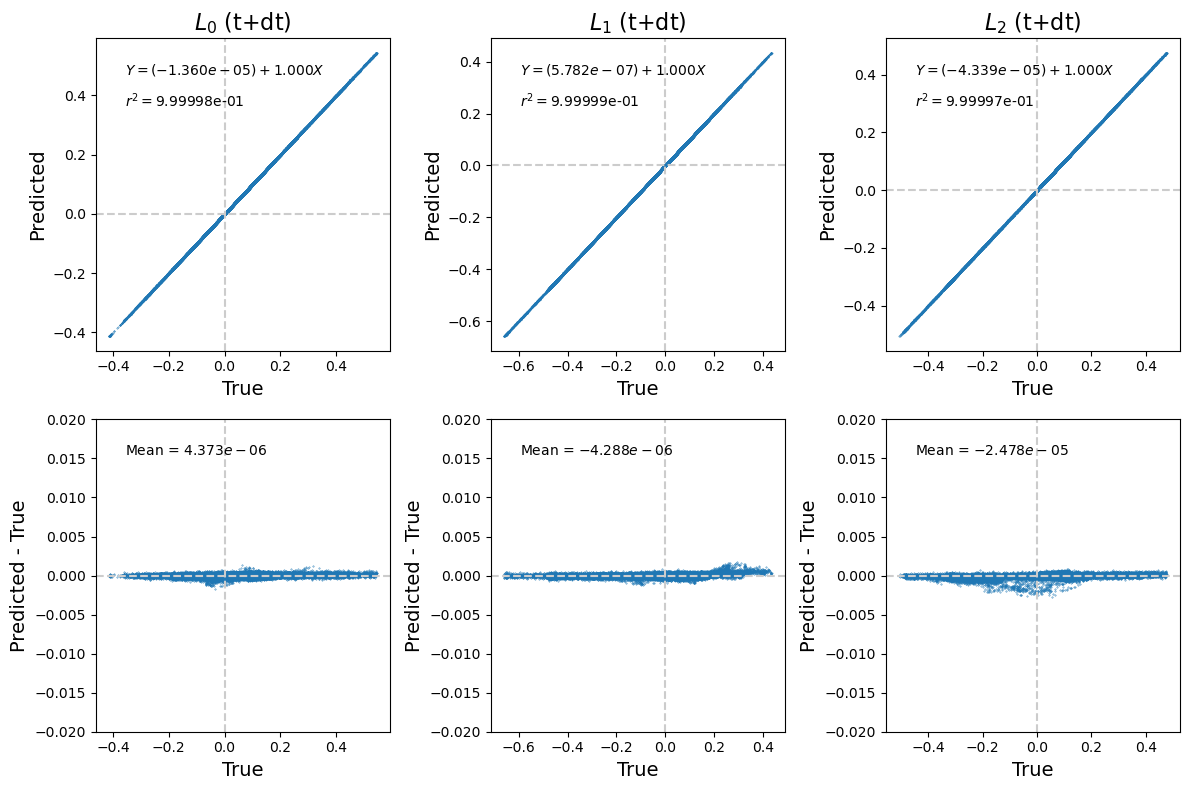

In [13]:
nw = 6
fs = 14

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

axes[0,0].scatter(trainrealL[:,0],trainpredL[:,0],s=0.1)
axes[0,0].axhline(y=0.0, color='0.8', linestyle='--')
axes[0,0].axvline(x=0.0, color='0.8', linestyle='--')
axes[0,0].set_xlabel(r'True',fontsize=fs)
axes[0,0].set_ylabel(r'Predicted',fontsize=fs)
axes[0,0].set_title(r'$L_0$ (t+dt)',fontsize=fs+2)
axes[0,0].text(0.1,0.9, r'$Y = ({:.3e}) + {:.3f}X$'.format(intercep[0],coefs[0]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[0,0].transAxes)
axes[0,0].text(0.1,0.8, r'$r^{2}=$'+'{:.5e}'.format(r2sc[0]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[0,0].transAxes)

axes[0,1].scatter(trainrealL[:,1],trainpredL[:,1],s=0.1)
axes[0,1].axhline(y=0.0, color='0.8', linestyle='--')
axes[0,1].axvline(x=0.0, color='0.8', linestyle='--')
axes[0,1].set_xlabel(r'True',fontsize=fs)
axes[0,1].set_ylabel(r'Predicted',fontsize=fs)
axes[0,1].set_title(r'$L_1$ (t+dt)',fontsize=fs+2)
axes[0,1].text(0.1,0.9, r'$Y = ({:.3e}) + {:.3f}X$'.format(intercep[1],coefs[1]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[0,1].transAxes)
axes[0,1].text(0.1,0.8, r'$r^{2}=$'+'{:.5e}'.format(r2sc[1]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[0,1].transAxes)


axes[0,2].scatter(trainrealL[:,2],trainpredL[:,2],s=0.1)
axes[0,2].axhline(y=0.0, color='0.8', linestyle='--')
axes[0,2].axvline(x=0.0, color='0.8', linestyle='--')
axes[0,2].set_xlabel(r'True',fontsize=fs)
axes[0,2].set_ylabel(r'Predicted',fontsize=fs)
axes[0,2].set_title(r'$L_2$ (t+dt)',fontsize=fs+2)
axes[0,2].text(0.1,0.9, r'$Y = ({:.3e}) + {:.3f}X$'.format(intercep[2],coefs[2]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[0,2].transAxes)
axes[0,2].text(0.1,0.8, r'$r^{2}=$'+'{:.5e}'.format(r2sc[2]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[0,2].transAxes)


axes[1,0].scatter(trainrealL[:,0],(trainpredL[:,0]-trainrealL[:,0]),s=0.1)
axes[1,0].axhline(y=0.0, color='0.8', linestyle='--')
axes[1,0].axvline(x=0.0, color='0.8', linestyle='--')
axes[1,0].set_ylim(-0.02,0.02)
axes[1,0].text(0.1,0.9, r'Mean = ${:.3e}$'.format(meanvals[0]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[1,0].transAxes)
axes[1,0].set_xlabel(r'True',fontsize=fs)
axes[1,0].set_ylabel(r'Predicted - True',fontsize=fs)

axes[1,1].scatter(trainrealL[:,1],(trainpredL[:,1]-trainrealL[:,1]),s=0.1)
axes[1,1].axhline(y=0.0, color='0.8', linestyle='--')
axes[1,1].axvline(x=0.0, color='0.8', linestyle='--')
axes[1,1].set_ylim(-0.02,0.02)
axes[1,1].text(0.1,0.9, r'Mean = ${:.3e}$'.format(meanvals[1]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[1,1].transAxes)
axes[1,1].set_xlabel(r'True',fontsize=fs)
axes[1,1].set_ylabel(r'Predicted - True',fontsize=fs)

axes[1,2].scatter(trainrealL[:,2],(trainpredL[:,2]-trainrealL[:,2]),s=0.1)
axes[1,2].axhline(y=0.0, color='0.8', linestyle='--')
axes[1,2].axvline(x=0.0, color='0.8', linestyle='--')
axes[1,2].set_ylim(-0.02,0.02)
axes[1,2].text(0.1,0.9, r'Mean = ${:.3e}$'.format(meanvals[2]), fontsize=10,horizontalalignment='left', verticalalignment='center', transform=axes[1,2].transAxes)
axes[1,2].set_xlabel(r'True',fontsize=fs)
axes[1,2].set_ylabel(r'Predicted - True',fontsize=fs)

plt.tight_layout()
#plt.savefig("Latent_Predictions.png",dpi=300)

## Compare the latent variables with the single category moments

In [15]:
nlatent = 3
sc = True # get the single category moments
trainM,traindMdt,trainrealbin0,trainrealbin1,trainpredbin0,trainpredbin1,trainpredL,trainrealL,trainrealL0=inference(model,trainloader,device,nlatent,singlecat=sc)
valM,valdMdt,valrealbin0,valrealbin1,valpredbin0,valpredbin1,valpredL,valrealL,valrealL0=inference(model,valloader,device,nlatent,singlecat=sc)
testM,testdMdt,testrealbin0,testrealbin1,testpredbin0,testpredbin1,testpredL,testrealL,testrealL0=inference(model,testloader,device,nlatent,singlecat=sc)

52000
26000
26214


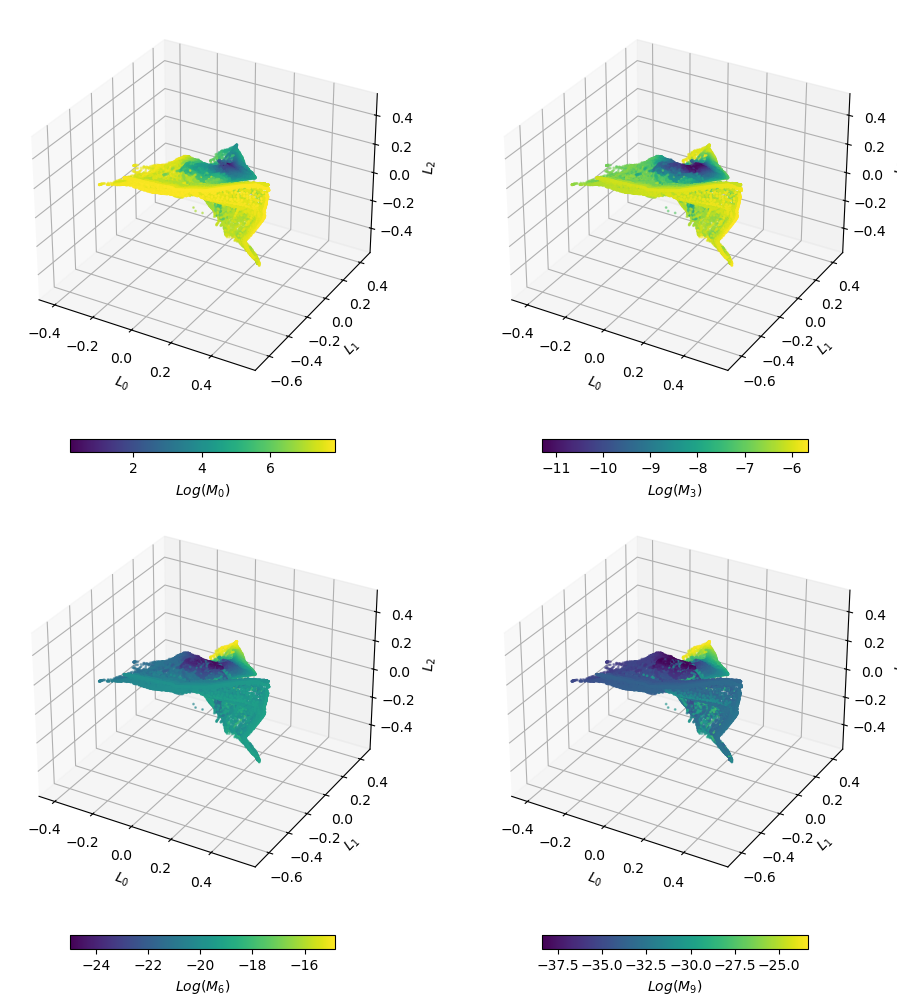

In [16]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(2,2,1,projection='3d')
ax1 = fig.add_subplot(2,2,2,projection='3d')
ax2 = fig.add_subplot(2,2,3,projection='3d')
ax3 = fig.add_subplot(2,2,4,projection='3d')

#[~mask2,:]
ss = 1
frac = 0.03
pp = 0.1
cm = "viridis"

i = 0
cc = np.log10(trainM[:,i,1])
a0 = ax0.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax0.set_xlabel(r'$L_{0}$')
ax0.set_ylabel(r'$L_{1}$')
ax0.set_zlabel(r'$L_{2}$')
#ax0.set_title(r'$M_{0}$')
fig.colorbar(a0,label=r"$Log(M_{0})$",location='bottom',fraction=frac,pad=pp)

i = 1
cc = np.log10(trainM[:,i,1])
a1=ax1.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax1.set_xlabel(r'$L_{0}$')
ax1.set_ylabel(r'$L_{1}$')
ax1.set_zlabel(r'$L_{2}$')
#ax1.set_title(r'$M_{3}$')
fig.colorbar(a1,label=r"$Log(M_{3})$",location='bottom',fraction=frac,pad=pp)

i = 2
cc = np.log10(trainM[:,i,1])
a2 = ax2.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax2.set_xlabel(r'$L_{0}$')
ax2.set_ylabel(r'$L_{1}$')
ax2.set_zlabel(r'$L_{2}$')
#ax2.set_title(r'$M_{6}$')
fig.colorbar(a2,label=r"$Log(M_{6})$",location='bottom',fraction=frac,pad=pp)

i = 3
cc = np.log10(trainM[:,i,1])
a3 = ax3.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax3.set_xlabel(r'$L_{0}$')
ax3.set_ylabel(r'$L_{1}$')
ax3.set_zlabel(r'$L_{2}$')
#ax3.set_title(r'$M_{9}$')
fig.colorbar(a3,label=r"$Log(M_{9})$",location='bottom',fraction=frac,pad=pp)

plt.tight_layout(pad=0.5)
plt.show()
#plt.savefig("Latent_vs_SingleCatM.png",dpi=300)

## Compare the latent variables with the two category moments

In [17]:
nlatent = 3
sc = False # get the two category moments
trainM,traindMdt,trainrealbin0,trainrealbin1,trainpredbin0,trainpredbin1,trainpredL,trainrealL,trainrealL0=inference(model,trainloader,device,nlatent,singlecat=sc)
valM,valdMdt,valrealbin0,valrealbin1,valpredbin0,valpredbin1,valpredL,valrealL,valrealL0=inference(model,valloader,device,nlatent,singlecat=sc)
testM,testdMdt,testrealbin0,testrealbin1,testpredbin0,testpredbin1,testpredL,testrealL,testrealL0=inference(model,testloader,device,nlatent,singlecat=sc)

52000
26000
26214


/tmp/ipykernel_4749/493907322.py:44: RuntimeWarning: divide by zero encountered in log10
  cc = np.log10(trainM[:,i,1,1])
/tmp/ipykernel_4749/493907322.py:53: RuntimeWarning: divide by zero encountered in log10
  cc = np.log10(trainM[:,i,1,1])
/tmp/ipykernel_4749/493907322.py:62: RuntimeWarning: divide by zero encountered in log10
  cc = np.log10(trainM[:,i,1,1])


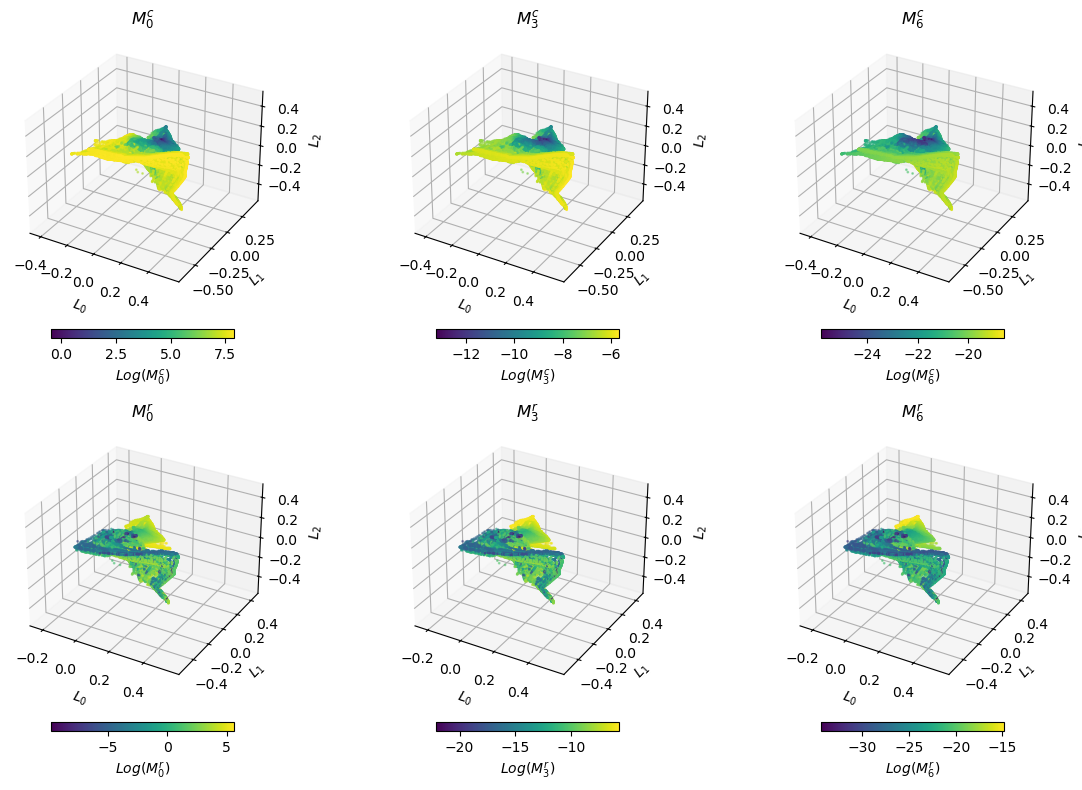

In [18]:
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(2,3,1,projection='3d')
ax1 = fig.add_subplot(2,3,2,projection='3d')
ax2 = fig.add_subplot(2,3,3,projection='3d')
ax3 = fig.add_subplot(2,3,4,projection='3d')
ax4 = fig.add_subplot(2,3,5,projection='3d')
ax5 = fig.add_subplot(2,3,6,projection='3d')
#ax3 = fig.add_subplot(1,4,4,projection='3d')

#[~mask2,:]
ss = 1
frac = 0.03
pp = 0.1
cm = "viridis"

i = 0
cc = np.log10(trainM[:,i,1,0])
a0 = ax0.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax0.set_xlabel(r'$L_{0}$')
ax0.set_ylabel(r'$L_{1}$')
ax0.set_zlabel(r'$L_{2}$')
ax0.set_title(r'$M_{0}^{c}$')
fig.colorbar(a0,label=r"$Log(M_{0}^{c})$",location='bottom',fraction=frac,pad=pp)

i = 1
cc = np.log10(trainM[:,i,1,0])
a1=ax1.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax1.set_xlabel(r'$L_{0}$')
ax1.set_ylabel(r'$L_{1}$')
ax1.set_zlabel(r'$L_{2}$')
ax1.set_title(r'$M_{3}^{c}$')
fig.colorbar(a1,label=r"$Log(M_{3}^{c})$",location='bottom',fraction=frac,pad=pp)

i = 2
cc = np.log10(trainM[:,i,1,0])
a2 = ax2.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax2.set_xlabel(r'$L_{0}$')
ax2.set_ylabel(r'$L_{1}$')
ax2.set_zlabel(r'$L_{2}$')
ax2.set_title(r'$M_{6}^{c}$')
fig.colorbar(a2,label=r"$Log(M_{6}^{c})$",location='bottom',fraction=frac,pad=pp)

i = 0
cc = np.log10(trainM[:,i,1,1])
a3 = ax3.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax3.set_xlabel(r'$L_{0}$')
ax3.set_ylabel(r'$L_{1}$')
ax3.set_zlabel(r'$L_{2}$')
ax3.set_title(r'$M_{0}^{r}$')
fig.colorbar(a3,label=r"$Log(M_{0}^{r})$",location='bottom',fraction=frac,pad=pp)

i = 1
cc = np.log10(trainM[:,i,1,1])
a4=ax4.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax4.set_xlabel(r'$L_{0}$')
ax4.set_ylabel(r'$L_{1}$')
ax4.set_zlabel(r'$L_{2}$')
ax4.set_title(r'$M_{3}^{r}$')
fig.colorbar(a4,label=r"$Log(M_{3}^{r})$",location='bottom',fraction=frac,pad=pp)

i = 2
cc = np.log10(trainM[:,i,1,1])
a5 = ax5.scatter(trainrealL[:,0],trainrealL[:,1],trainrealL[:,2],s=ss,c=cc,cmap=cm)
ax5.set_xlabel(r'$L_{0}$')
ax5.set_ylabel(r'$L_{1}$')
ax5.set_zlabel(r'$L_{2}$')
ax5.set_title(r'$M_{6}^{r}$')
fig.colorbar(a5,label=r"$Log(M_{6}^{r})$",location='bottom',fraction=frac,pad=pp)

plt.tight_layout()
plt.show()
#plt.savefig("Latent_vs_TwoCatM.png",dpi=300)

## Plot the latent manifold along the two directions of greatest variance

In [19]:
pca = PCA(n_components=3)
    
nspca = pca.fit_transform(trainrealL[:,:])
    
npc = np.arange(0,nlatent)
exp = pca.explained_variance_ratio_

In [20]:
def plot_reconstructed_pca(model,n,pca,nspca,figname,saveplots=False):
    # n = # of plots to visualize for latent space (n by n)
    # ncomp = # components of pca
    # pca = sklearn class
    # nspca = transformed variables from pca analysis
    
    ncomp = nspca.shape[1]
    fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(12,12))
    grid_z = np.zeros((ncomp,n))

    aa = np.arange(0,100,100/n)+100/n/2
    print(100/n,aa)
    print(aa.shape,grid_z.shape)
    
    xvals = np.zeros((2,35,n,n))
    
    for i in range(0,ncomp):
        grid_z[i,:]=np.percentile(nspca[:,i],aa)
    
    for i in range(0,n):
        for j in range(0,n):
            
            a = np.zeros([1,ncomp])
            
            a[0,0]=grid_z[0,i]
            a[0,1]=grid_z[1,j]
            
            for k in range(2,ncomp):
                a[0,k]=np.percentile(nspca[:,k],50) 
 
            z = pca.inverse_transform(a)
           
            z_cond =torch.Tensor(z).to(device)

            xhat = model.decoder(z_cond) #.to('cpu').detach().numpy()
            

            xvals[:,:,i,j]=xhat.to('cpu').detach().numpy()

            
            ax = axs[i,j]

            ax.plot(xvals[0,:,i,j],label="Number",c='g')
            ax.plot(xvals[1,:,i,j],label="Mass",c='b')

            ax.set_ylim(0.0,1.0)
            
            if j==0:
                ylabels = grid_z[0,i].round(decimals=3).astype(str)
                ydeciles = aa[i].astype(int).astype(str)
                
                #ax.set_ylabel(r'$z_{1}=$'+ylabels,rotation=0,ha='right')
                ax.set_ylabel(ydeciles+"%",rotation=0,ha='right',fontsize=12)
            if i==n-1:
                xlabels = grid_z[1,j].round(decimals=3).astype(str)
                #ax.set_xlabel(r'$z_{0}=$'+xlabels,rotation = 90)
                xdeciles = aa[j].astype(int).astype(str)
                ax.set_xlabel(xdeciles+"%",fontsize=12)
            
            
            ax.set_yticks([])
            if i==0 and j==(n-1):
                lgd=ax.legend(bbox_to_anchor=(1, 1.05),frameon=False)

    plt.subplots_adjust(wspace=0, hspace=0)

    if saveplots:
        plt.savefig(figname,bbox_extra_artists=(lgd,), bbox_inches='tight')
    else:
        plt.show()
    
    return xvals

10.0 [ 5. 15. 25. 35. 45. 55. 65. 75. 85. 95.]
(10,) (3, 10)


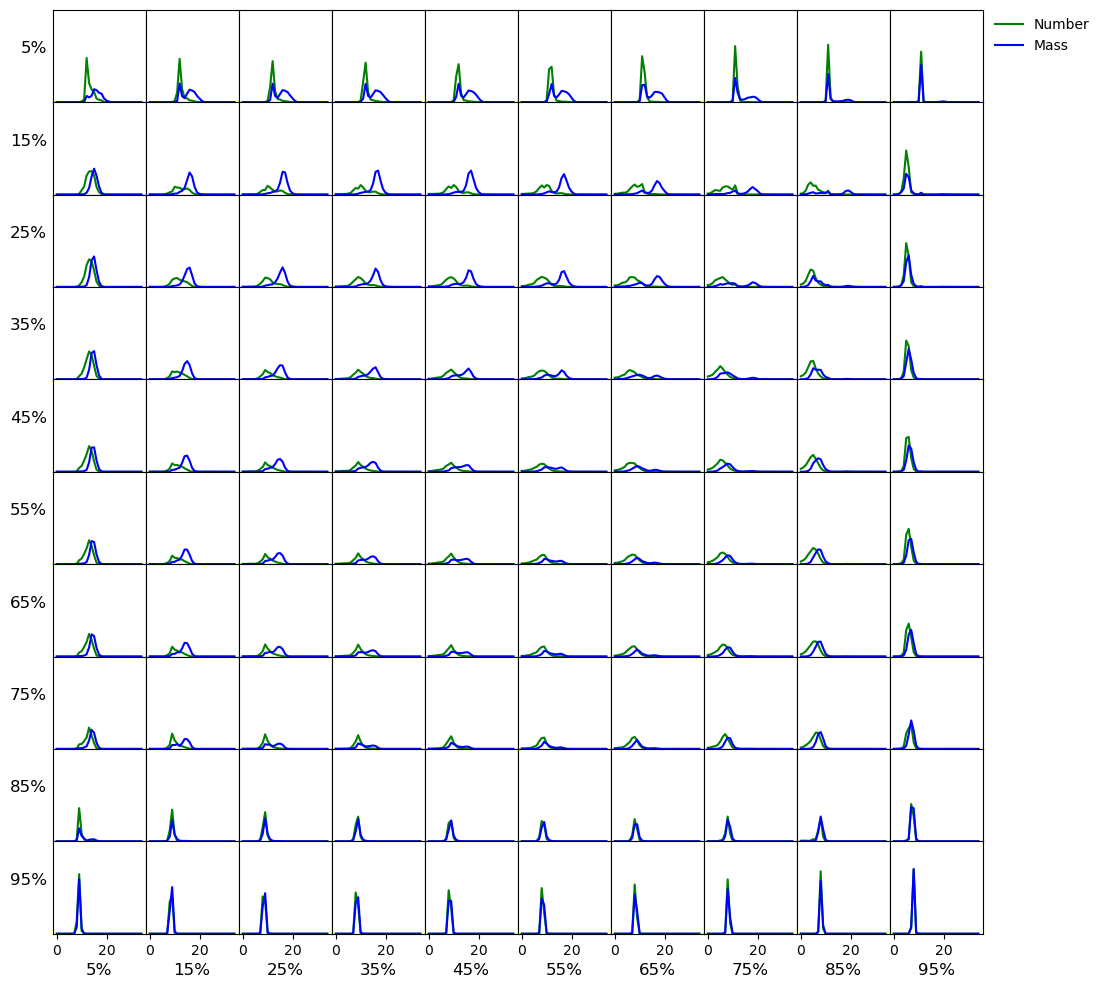

In [22]:
figname = "PCA_Lp0Lp1_LatentSpace_n5.png"
n = 10 
xvals=plot_reconstructed_pca(model,n,pca,nspca,figname,saveplots=False)